# Performance Margins

As established in block A: *our model is always terrible*. Therefore, we might want to know how prone our controller is to destabilizing the system, because our model is wrong. There are three popular measures for this: the gain margin, the phase margin, and the stability margin. They're quite easy:
- Gain margin $g$: $\argmin_{g}$ such that $g L(s)$ becomes unstable,
- Phase margin $\phi$: $\argmin_{|\phi|}$ such that $e^{\phi i}L(s)$ becomes unstable (think about how that translates to a time delay!),
- Stability margin $s_m$: minimal distance between Nyquist plot, $L(\Gamma_s)$, and the point -1.

You can read the gain and phase margins from a bode plot, but not the stability margin. In this sense a Nyquist plot contains more information than a Bode plot. Anyways, lets plot those margins for a loop function.

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.gridspec import GridSpec
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")
from helperFunctions import *
setPlotStyle()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Gain margin = 1.63
Phase margin = 65.63 degrees
Stability margin = 0.37


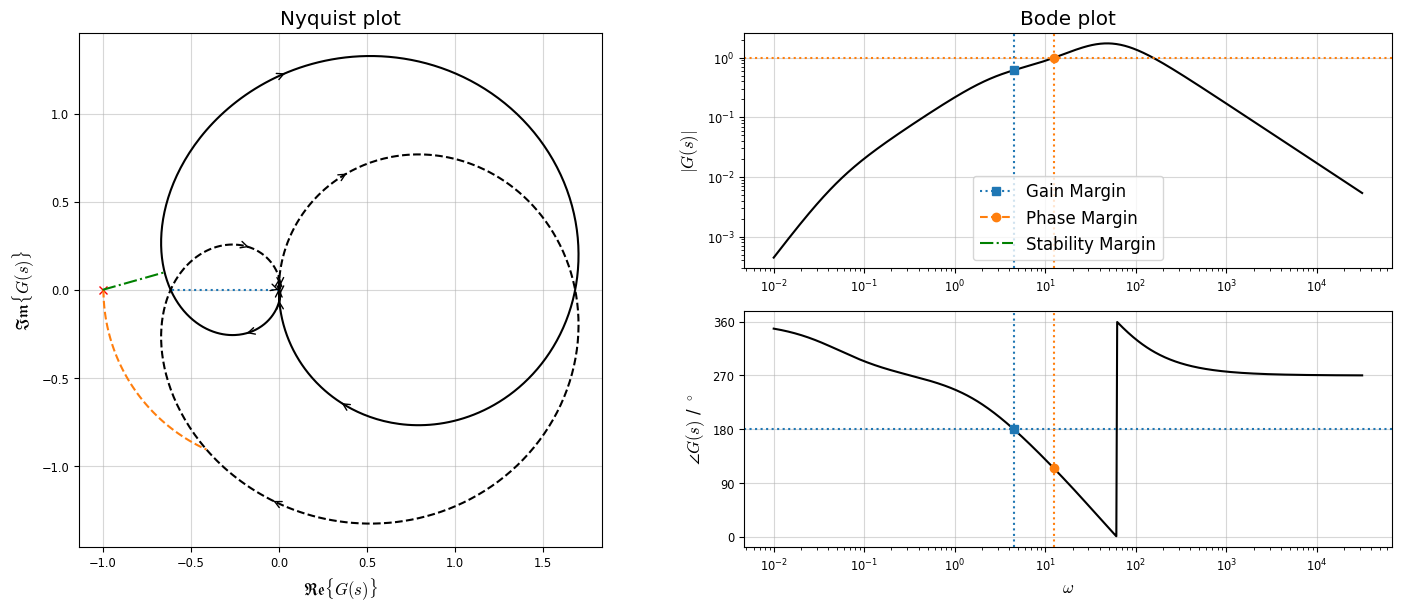

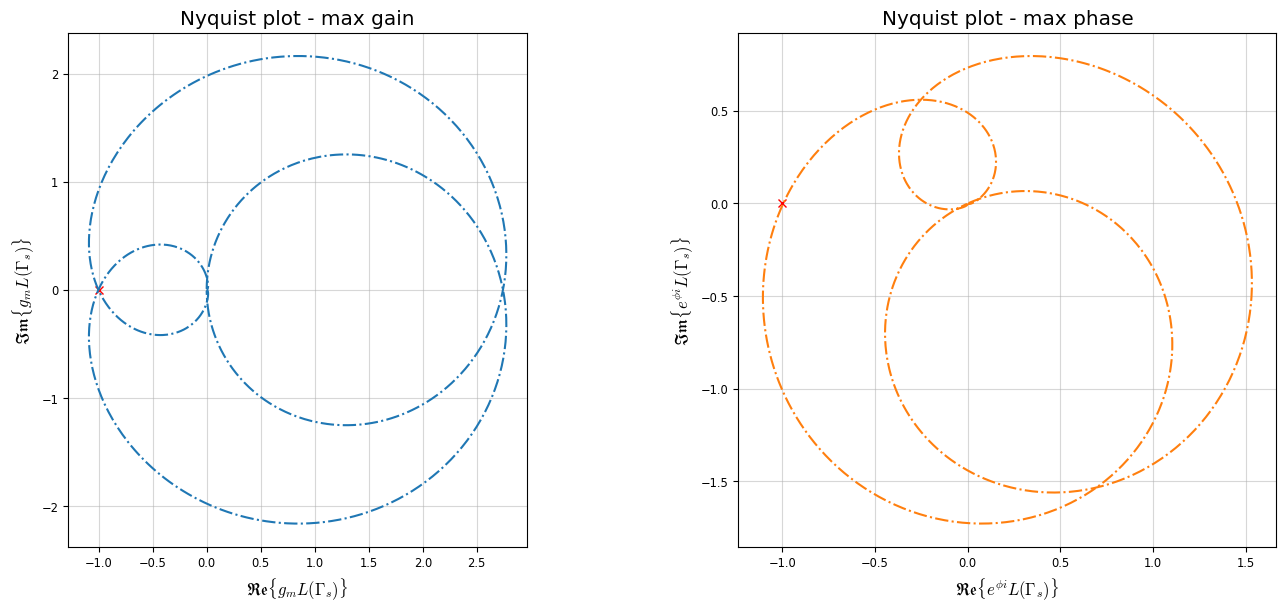

In [ ]:
OM = np.logspace(-2, 4.5, 700)
S = OM*1j

L1 = lambda s :  170* s**2*(s - 1e1) / ((s + 5e-2) * (s + 3) * (s + 50)**2)

L1_eval1 = L1(S)
L1_eval2 = L1(np.flip(-S))

L1mag_eval1 = np.abs(L1_eval1)
L1ph_eval1 = np.angle(L1_eval1, deg=True)
L1ph_eval1 = unwrap_angle(L1ph_eval1)
L1ph_eval1 %= 360

fig = plt.figure(num="Bode - Nyquist relation")
gs = GridSpec(2,2, figure=fig)
ax = [fig.add_subplot(a) for a in [gs[:, 0], gs[0, 1], gs[1, 1]]]

ax[0].set(title="Nyquist plot", aspect='equal',
          xlabel=r"$\mathfrak{Re}\{L(\Gamma_s)\}$", ylabel=r"$\mathfrak{Im}\{L(\Gamma_s)\}$")
ax[1].set(title="Bode plot", ylabel = "$|G(s)|$")
ax[2].set(xlabel = r"$\omega$", ylabel = r"$\angle G(s)$ / ${}^\circ$")
ax[2].yaxis.set_major_locator(MultipleLocator(90))

drawContour(ax[0], L1_eval1, c='k', ls='-')
drawContour(ax[0], L1_eval2, c='k', ls='--')
ax[1].loglog(OM, L1mag_eval1, 'k')
ax[2].semilogx(OM, L1ph_eval1, 'k')


fig2, ax2 = plt.subplots(1,2)
ax2[0].set(title="Nyquist plot - max gain",  aspect='equal',
          xlabel=r"$\mathfrak{Re}\{g_m L(\Gamma_s)\}$", ylabel=r"$\mathfrak{Im}\{g_m L(\Gamma_s)\}$")
ax2[1].set(title="Nyquist plot - max phase",  aspect='equal',
          xlabel=r"$\mathfrak{Re}\{e^{\phi i}L(\Gamma_s)\}$", ylabel=r"$\mathfrak{Im}\{e^{\phi i}L(\Gamma_s)\}$")

[x.plot([-1], [0], 'xr') for x in [ax[0], ax2[0], ax2[1]]]


## Determine gain margin
ax[2].axhline(180., c='C0', ls=':')

idx_g_m = np.abs((L1ph_eval1 - 180.)).argmin()
l1, = ax[2].plot([OM[idx_g_m]], [L1ph_eval1[idx_g_m]], 's:', c='C0', label="Gain Margin")
ax[1].plot([OM[idx_g_m]], [L1mag_eval1[idx_g_m]], 's', c='C0')
[ax[i].axvline(OM[idx_g_m], c='C0', ls=':') for i in [1, 2]]
g_m = 1/L1mag_eval1[idx_g_m]
[ax2[0].plot(g_m*L1_evalq.real, g_m*L1_evalq.imag, c='C0', ls='-.') for L1_evalq in [L1_eval1, L1_eval2]]

ax[0].plot([0, -L1mag_eval1[idx_g_m]], [0,0], c='C0', ls=':')

print(f"Gain margin = {g_m:1.2f}")

## Determine phase margin
ax[1].axhline(1., c='C1', ls=':')

idx_phi_m_candidates = [idx for idx in range(L1mag_eval1.size - 1) if (L1mag_eval1[idx]-1) * (L1mag_eval1[idx+1]-1) < 0. 
                        and abs(L1ph_eval1[idx]) >= 90. ]
idx_phi_m = idx_phi_m_candidates[0]
l2, = ax[1].plot(OM[idx_phi_m], L1mag_eval1[idx_phi_m], 'o--', c='C1', label="Phase Margin")
ax[2].plot(OM[idx_phi_m], L1ph_eval1[idx_phi_m], 'o', c='C1')
[ax[i].axvline(OM[idx_phi_m], c='C1', ls=':') for i in [1, 2]]
phi_m = np.abs(180 + L1ph_eval1[idx_phi_m])
[ax2[1].plot((np.exp(np.deg2rad(phi_m)*1j)*L1_evalq).real, (np.exp(np.deg2rad(phi_m)*1j)*L1_evalq).imag, 
            c='C1', ls='-.') for L1_evalq in [L1_eval1, L1_eval2]]

a = L1mag_eval1[idx_phi_m] * np.exp(np.linspace(0, np.asin(np.sin(phi_m * np.pi / 180.)))*1j)
ax[0].plot(-a.real, a.imag, c='C1', ls='--')
print(f"Phase margin = {abs(np.asin(np.sin(phi_m * np.pi / 180.)) * 180. / np.pi):1.2f} degrees")

## Determine stability margin
idx_s_m = np.abs(L1_eval1 + 1).argmin()
s_m = np.abs(L1_eval1 + 1).min()
l3, = ax[0].plot([-1, L1_eval1[idx_s_m].real],
           [0, L1_eval1[idx_s_m].imag],
           'g-.', label="Stability Margin")

ax[1].legend(handles=[l1,l2,l3])
print(f"Stability margin = {s_m:1.2f}")

display(fig, fig2)
